<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/OpenMined/PipelineDP/blob/main/examples/restaurant_visits.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/OpenMined/PipelineDP/blob/main/examples/restaurant_visits.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# About this codelab
This codelab demonstrates the core functionality of PipelineDP. The codelab targets users who would like to apply an end-to-end solution to their dataset regardless of their level of knowledge of differential privacy (DP). We recommend all readers take a look at the [“Background”](https://colab.sandbox.google.com/github/OpenMined/PipelineDP/blob/main/examples/restaurant_visits.ipynb#scrollTo=Background) section which contains the key definitions. For users who have some experience with DP, we recommend starting with the “[Framework-specific API](https://colab.sandbox.google.com/github/OpenMined/PipelineDP/blob/main/examples/restaurant_visits.ipynb#scrollTo=Framework_specific_API_Beam)” section. It explains how to run the basic differentially private aggregations such as count and sum on Apache Beam and Spark. For the reader who would like to have more flexibility and try some “advanced” DP features, we recommend reading the [“Core API”](https://colab.sandbox.google.com/github/OpenMined/PipelineDP/blob/main/examples/restaurant_visits.ipynb#scrollTo=Core_API) section. It demonstrates how to design a generic pipeline that can be used with various execution engines. All readers should run the instructions in [“Install dependencies”](https://colab.sandbox.google.com/github/OpenMined/PipelineDP/blob/main/examples/restaurant_visits.ipynb#scrollTo=Install_dependencies_and_download_data) and [“Load and inspect the data”](https://colab.sandbox.google.com/github/OpenMined/PipelineDP/blob/main/examples/restaurant_visits.ipynb#scrollTo=Load_and_inspect_the_data) in order to prepare their environment.


# Background

## Colab example
The colab is based on the following scenario: imagine we have a collection of records that represent restaurant visits for 7 days. Each visit has a visitor ID, and each visitor may enter the restaurant multiple times a day and several days a week. We would like to calculate some DP statistics such as the number of visits per week day, the number of distinct visitors per week day, the total amount of money people spend at the restaurant per week day.

## Differential privacy
Differential privacy offers a tradeoff between the accuracy of aggregations over statistical databases (for example, mean) and the chance of learning something about individual records in the database. This tradeoff is an easily configured parameter; you can increase privacy by decreasing the accuracy of your statistics (or vice versa). Unlike other anonymization schemes (such as k-anonymity) that completely fail once too much data is released, differential privacy degrades slowly when more data is released.

You can find a very high-level, non-technical introduction to differential privacy in [this blog post](https://desfontain.es/privacy/friendly-intro-to-differential-privacy.html), and a more detailed explanation of how it works in the book ["The Algorithmic Foundations of Differential Privacy"](https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf).

## Key definitions
**(Privacy) budget**: every operation leaks some information about individuals. The total privacy cost of a pipeline is the sum of the costs of its releases. You want this to be below a certain total cost. That's your budget. Typically, the greek letters 'epsilon' and 'delta' (ϵ and δ) are used to define the budget.

**Partition**: a partition is a subset of the data corresponding to a given value of the aggregation criterion. In our example, the partitions are the seven days of the week. 

**Partition key**: this is the partition identifier. Since in our example the data are aggregated per day, the partition key is a day.

**Privacy ID:** an ID of the unit of privacy that we are protecting. For example, if we protect the presence of the user in a dataset, the privacy ID is the user ID. In our colab, the privacy ID is a visitor ID.

## PipelineDP
PipelineDP is a Python end-to-end framework for generating differentially private statistics. PipelineDP provides a high-level API for anonymizing data using Apache Beam It also has a core API that can be used to define a generic pipeline which can be then run on various engines. In the following section we demonstrate both APIs.

# Install dependencies and download data


In [1]:
#@markdown Install dependencies and download data

import os
os.chdir('/content')
!pip install pipeline-dp apache_beam
# If you'd like to test the most recent version of PipelineDP, uncomment the
# following lines and comment-out the previous line.
# !git clone https://github.com/OpenMined/PipelineDP.git
# !pip install -r PipelineDP/requirements.dev.txt

import sys
sys.path.insert(0,'/content/PipelineDP')

#Download restaurant dataset from github
!wget https://raw.githubusercontent.com/google/differential-privacy/main/examples/go/data/week_data.csv

from IPython.display import clear_output
clear_output()

import apache_beam as beam
from apache_beam.runners.portability import fn_api_runner
from apache_beam.runners.interactive import interactive_runner
from apache_beam.runners.interactive.interactive_beam import *
from dataclasses import dataclass
import pipeline_dp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and inspect the data
The dataset used in this Colab is a simulated dataset of visits to some restaurant during a 7 day period. The code below loads the dataset in a DataFrame and prints some of its records.

In [2]:
#@markdown Load and inspect the data
df = pd.read_csv('week_data.csv')
df.rename(inplace=True, columns={'VisitorId' : 'user_id', 'Time entered' : 'enter_time', 'Time spent (minutes)' : 'spent_minutes', 'Money spent (euros)' : 'spent_money', 'Day' : 'day'})
rows = [index_row[1] for index_row in df.iterrows()]
df.head()

user_id enter_time  spent_minutes  spent_money  day
0      580     9:27AM             29           17    1
1     1215     9:16AM             45           18    1
2      448    11:55AM             12           16    1
3      125    10:47AM             27           20    1
4      484    11:08AM             35           13    1

The goal of this Colab is to demonstrate how to compute the number of visits and amount of money spent for each day in a DP manner.

The plots below demonstrate the non-private result.

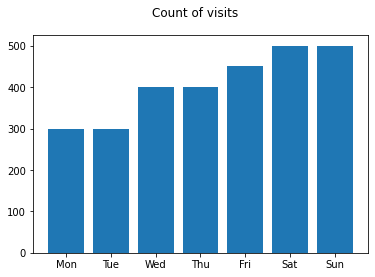

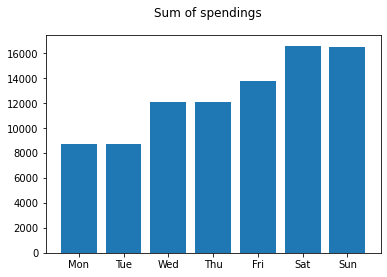

In [3]:
#@title Non-private statistics
non_dp_count = [0] * 7
non_dp_sum = [0] * 7
days = range(1, 7)
for row in rows:
  index = row['day'] - 1
  non_dp_count[index] += 1
  non_dp_sum[index] += row['spent_money']

days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
plt.bar(days, non_dp_count)
plt.suptitle('Count of visits')
plt.show()

plt.bar(days, non_dp_sum)
plt.suptitle('Total spending')
plt.show()


# Core API
Before executing instructions in this section, please make sure you’ve run [“install dependencies”](https://colab.sandbox.google.com/github/OpenMined/PipelineDP/blob/main/examples/restaurant_visits.ipynb#scrollTo=Install_dependencies_and_download_data) and [“Load and inspect the data”](https://colab.sandbox.google.com/github/OpenMined/PipelineDP/blob/main/examples/restaurant_visits.ipynb#scrollTo=Load_and_inspect_the_data) to configure your workspace.
 
PipelineDP allows users to define a generic anonymization pipeline that can be run on different pipeline frameworks. In this section we demonstrate how to define a pipeline and run it locally. The pipeline definition includes the following steps: 
1. Select the framework on which the pipeline will be run (e.g., local or Beam).
2. Configure the total amount of privacy budget and the budget allocation strategy.
3. Instantiate DPEngine which executes the DP operations.
4. Define the privacy ID, partition key and value extractors.
5. Configure aggregations.
6. Run the pipeline!

The following section explains how to port a pipeline to various frameworks. 


## Select the framework (PipelineBackend)
`PipelineBackend` is an object which encapsulates the pipeline framework. In this example we use `LocalBackend` in order to run the pipeline locally. 

In [30]:
backend = pipeline_dp.LocalBackend()

## Configure privacy budget (BudgetAccountant)
`BudgetAccountant` defines the total amount of privacy budget that will be spent on DP aggregations within the program. It automatically splits the budget among all DP aggregations. Depending on the type of `BudgetAccountant` different budget allocation strategies can be applied. In this codelab we use `NaiveBudgetAccountant`, which implements basic composition.

In [41]:
budget_accountant = pipeline_dp.NaiveBudgetAccountant(total_epsilon=1, total_delta=1e-6)

## DPEngine instantiation
`DPEngine` performs DP operations. It’s instantiated by the code below.

In [42]:
dp_engine = pipeline_dp.DPEngine(budget_accountant, backend)

## Configure data extractors
Now we need to tell PipelineDP how to extract the privacy ID, the partition key and the value to be aggregated from the input data. For this, we configure `DataExtractors` as below. The extractor functions will be applied to each row of the input data.

In [33]:
data_extractors = pipeline_dp.DataExtractors(
   partition_extractor=lambda row: row.day,
   privacy_id_extractor=lambda row: row.user_id,
   value_extractor=lambda row: row.spent_money)

## Configure DP aggregations
In this section we will demonstrate how to configure the DP aggregations that will be run on the dataset. For this, we need to define an `AggregationParams` object with the following properties:
* `noise_kind` defines the distribution of the noise that is added to make the result differentially private.
* `methods` is a collection of aggregation methods that will be executed on the dataset. In our example we count visits and sum-up visitor spending per day and hence we use `COUNT` and `SUM` aggregations.
* `max_partitions_contributed` specifies the upper bound on the number of partitions to which one privacy ID can contribute. All contributions in excess of the limit will be discarded. The contributions to be discarded are chosen randomly.
* `max_contributions_per_partition` is the maximum number of times a privacy ID can contribute to a partition. For instance, if in our example it’s set to 2, that means that for each visitor we will count up to 2 visits and corresponding spendings per day.
* `min_value` and `max_value` are the lower and upper bound on the privacy ID contributions. Values less than min_value are “clamped” to the min_value, and values greater than the max_value bound are clamped to the max_value. This is necessary in order to limit the sensitivity.
* `public_partitions` is a collection of the partition keys that will appear in the result. In our example we’d like to see the statistics for each week day and hence pass `range(1, 8)` as public partitions. If we wanted to compute the result for the week-end only, we would pass `range(6, 8)`. If `public_partitions` is not specified, the pipeline will select partitions to release in a DP manner.

In [34]:
params = pipeline_dp.AggregateParams(
   noise_kind=pipeline_dp.NoiseKind.LAPLACE,
   metrics=[pipeline_dp.Metrics.COUNT, pipeline_dp.Metrics.SUM],
   max_partitions_contributed=3,
   max_contributions_per_partition=2,
   min_value=0,
   max_value=60,
   public_partitions=list(range(1, 8)))

## Run the pipeline
Now, that all the parameters have been defined, call `aggregate` on the `DPEngine` instance. This is a lazy operation, it builds the computational graph but doesn't trigger any data processing. Next, we must call `budget_accountant.compute_budgets()`so that it allocates a privacy budget to the aggregations. Finally, we can trigger the pipeline computation and obtain the result.

Due to the stateful nature of the `BudgetAccountant`, the code below can be executed only once. If you'd like to recompute the DP result, you'll need to create new `BudgetAccountant` and `DPEngine` instances. This reminds us that each time we run the pipeline, we consume privacy budget.

In [43]:
# Build computational graph for aggregation
dp_result = dp_engine.aggregate(rows, params, data_extractors)
# Compute budget per each DP operation. 
budget_accountant.compute_budgets()
# Run computation.
dp_result = list(dp_result)

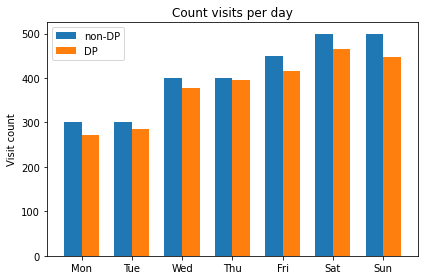

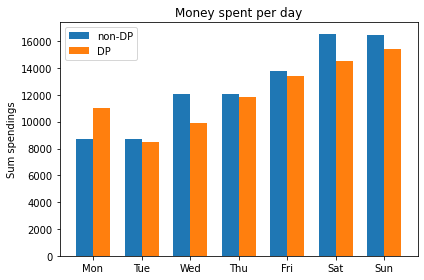

In [37]:
#@markdown ##Inspect the result
#@markdown Below you can see the DP and non-DP results.

dp_sum = [0] * 7 
dp_count = [0] * 7 
for count_sum_per_day in dp_result:
  index =  count_sum_per_day[0] - 1
  dp_count[index] = count_sum_per_day[1][0]
  dp_sum[index] = count_sum_per_day[1][1]

days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
x = np.arange(len(days))

width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, non_dp_count, width, label='non-DP')
rects2 = ax.bar(x + width/2, dp_count, width, label='DP')
ax.set_ylabel('Visit count')
ax.set_title('Count visits per day')
ax.set_xticks(x)
ax.set_xticklabels(days)
ax.legend()
fig.tight_layout()
plt.show()

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, non_dp_sum, width, label='non-DP')
rects2 = ax.bar(x + width/2, dp_sum, width, label='DP')
ax.set_ylabel('Sum spendings')
ax.set_title('Money spent per day')
ax.set_xticks(x)
ax.set_xticklabels(days)
ax.legend()
fig.tight_layout()
plt.show()


The result includes 7 partitions: 1 partition per day, and 2 values associated with each partition: the count of visits and total spending.

## Partition selection
In our example we used “public partitions”. This means, we explicitly defined the partition keys that appear in the result. It’s possible in this case because the week days are publicly known information. Defining public partitions isn’t always possible. If partition keys are based on user data rather than being public information, they are private information and need to be calculated using DP. If you do not specify public_partitions, PipelineDP automatically calculates partition keys with DP. As a consequence, the DP result will include only partitions that have sufficiently many contributing privacy IDs to ensure that a single privacy ID cannot impact the structure of the returned result. You can learn more about private partition selection in [this blog post](https://desfontain.es/privacy/almost-differential-privacy.html).

## Public partitions
Public partitions have a couple of caveats. First, you really need to make sure that the provided partitions are based on public knowledge or derived using differential privacy. Second, public partitions with no contributions from users will appear in the DP statistics with noisy values. This ensures that an attacker cannot know which partitions users contributed to by looking at the structure of the results. This can be detrimental for utility, as empty partitions will be all noise and no signal.

# Porting your pipeline on different frameworks

It’s easy to port the pipeline that we’ve defined in the "Core API" section to a different framework such as Beam. To do this, we need to copy the input data into a collection accepted by Beam (`PCollection`) and use `BeamBackend` instead of `LocalBackend`. Similarly, the pipeline could be run on Spark with equivalent changes.
To demonstrate using Beam below, we first move all framework-independent logic in a run_pipeline function and then call it with the framework-specific parameters.

In [11]:
# Framework independent function
def run_pipeline(data, ops):
  budget_accountant = pipeline_dp.NaiveBudgetAccountant(total_epsilon=1, total_delta=1e-7)

  dp_engine = pipeline_dp.DPEngine(budget_accountant, ops)

  params = pipeline_dp.AggregateParams(noise_kind = pipeline_dp.NoiseKind.LAPLACE,
                                      metrics=[pipeline_dp.Metrics.COUNT, pipeline_dp.Metrics.SUM],
                                      max_partitions_contributed=7,
                                      max_contributions_per_partition=2,
                                      min_value=0,
                                      max_value=100,
                                      public_partitions=list(range(1, 8)))

  data_extractors = pipeline_dp.DataExtractors(privacy_id_extractor = lambda row: row.user_id,
                                              partition_extractor = lambda row: row.day,
                                              value_extractor = lambda row: row.spent_money)

  dp_result = dp_engine.aggregate(data, params, data_extractors)

  budget_accountant.compute_budgets()

  return dp_result

# Beam demo
runner = fn_api_runner.FnApiRunner()  # local runner

with beam.Pipeline(runner=runner) as pipeline:
    beam_data = pipeline | beam.Create(rows)
    backend = pipeline_dp.BeamBackend()
    dp_result = run_pipeline(beam_data, backend)   
    dp_result | beam.Map(print)

(1, [322.10610046214424, 9195.14275841415])
(7, [481.1850680805801, 18026.400029487908])
(3, [405.3920060338278, 12112.681617956609])
(5, [485.00121798118926, 21584.445443578064])
(2, [379.9984859788965, 8433.152831096202])
(6, [568.6533543976257, 17409.165902819484])
(4, [436.3969806227251, 10253.25948811695])


# Framework-specific API: Beam
Before executing instructions in this section, please make sure you’ve run [“install dependencies”](https://colab.sandbox.google.com/github/OpenMined/PipelineDP/blob/main/examples/restaurant_visits.ipynb#scrollTo=Install_dependencies_and_download_data) and [“Load and inspect the data”](https://colab.sandbox.google.com/github/OpenMined/PipelineDP/blob/main/examples/restaurant_visits.ipynb#scrollTo=Load_and_inspect_the_data) to configure your workspace.


## Load Beam dependencies
First, we import Beam dependencies and load the runner:


In [44]:
#@markdown Load Beam dependencies

import pipeline_dp.private_beam as pbeam

runner = fn_api_runner.FnApiRunner()

## Pipeline overview
Then, we configure and run the pipeline as presented below. You can simply run the code below and observe the result. 


In [45]:
with beam.Pipeline(runner=runner) as pipeline:
    budget_accountant = pipeline_dp.NaiveBudgetAccountant(
                total_epsilon=1, total_delta=1e-8)

    beam_data = pipeline | beam.Create(rows)
    # Creating PrivatePCollection
    pcol = beam_data | pbeam.MakePrivate(budget_accountant=budget_accountant, privacy_id_extractor = lambda row: row.user_id)

    # Createa params for sum
    sum_params = pipeline_dp.aggregate_params.SumParams(
                noise_kind=pipeline_dp.NoiseKind.GAUSSIAN,
                max_partitions_contributed=7,
                max_contributions_per_partition=2,
                min_value=1,
                max_value=100,
                budget_weight=1,
                public_partitions=None,
                partition_extractor=lambda row: row.day,
                value_extractor=lambda row: row.spent_money) 
    dp_result = pcol | pbeam.Sum(sum_params) 

    budget_accountant.compute_budgets()

    dp_result | beam.Map(print)

(5, 7458.091159876506)
(3, 10381.319975144035)
(7, 20996.5429591567)
(1, 7316.615952457176)
(2, 20965.896481984564)
(6, 15890.38387970232)
(4, 8689.597153124425)


In the next sections we detail each step of the pipeline above.

## Configure privacy budget (BudgetAccountant)
`BudgetAccountant` defines the total amount of privacy budget that will be spent on DP aggregations within the program and automatically splits it among all DP aggregations. Different `BudgetAccountant` implementations will allocate budget in different ways. In this codelab we use NaiveBudgetAccountant, which implements basic composition. The budget accountant is created in the code-snippet below.
```
budget_accountant = pipeline_dp.NaiveBudgetAccountant(total_epsilon=1, total_delta=1e-8)
```

## Create a PrivatePCollection
`PrivatePCollection` is a wrapper for the input data on which the DP operations can be run. The code-snippet below wraps the input data in a Beam pipeline and then turns it into a `PrivatePCollection` object. As a part of a `PrivatePCollection` definition, we tell PipelineDP from which budget accountant the budget needs to be charged, and how to extract a privacy ID (e.g., user ID) from an input data row.
```
beam_data = pipeline | beam.Create(rows)
# Creating PrivatePCollection
pcol = beam_data | pbeam.MakePrivate(budget_accountant=budget_accountant, privacy_id_extractor = lambda row: row.user_id)
```

## Compute DP sum
Before computing DP sum, we need to configure all necessary parameters. More precisely, we need to define the following:
* `noise_kind` defines the distribution of the noise that is added to make the result differentially private.
* `max_partitions_contributed` specifies the upper bound on the number of partitions that can be contributed by a privacy ID. All excess contributions will be discarded. The choice of which contributions will be discarded is random.
* `max_contributions_per_partition` is the maximum number of times a privacy ID can contribute to a partition. For instance, if in our example it’s set to 2 which means that for each visitor we will take into account up to 2 visits and corresponding spending per day.
* `min_value` and `max_value` are the lower and upper bound on the privacy ID contributions. Values less than the lower bound are “clamped” to `min_value`, and values greater than the higher bound are clamped to `max_value`. This is necessary in order to limit the sensitivity.
* `budget_weight` is the relative weight of this operation (sum in our example) in the budget allocation. Recall that we defined the total amount of budget in a `BudgetAccountant`. The budget is split among all operations run on the corresponding PrivatePCollection. The way the budget is split can be controlled through budget_weight. The higher the relative weight is, the more budget is allocated to the operation, and hence the more precise the result is.
* `public_partitions` is a collection of all the partition keys that will appear in the result. In our example we’d like to see the statistics for each week day and hence pass `range[1, 8)` as public partitions. If we wanted to compute the result for the week-end only, we would pass `range[6, 8)`. If `public_partitions` is not specified, the pipeline will select partitions to release in a DP manner.
* `partition_extractor` defines how to extract the partition key from an element of the input data. In our example we compute daily statistics and hence a partition key is a day.
* `value_extractor` defines how to extract the value to be aggregated from an element of the input data. In our example we compute sum of visitor spending per day, and hence the value to be aggregated is the amount of money spent at a visit.

Next, we call DP sum.
```
sum_params = pipeline_dp.aggregate_params.SumParams(
             noise_kind=pipeline_dp.NoiseKind.GAUSSIAN,
             max_partitions_contributed=7,
             max_contributions_per_partition=2,
             low=1,
             high=100,
             budget_weight=1,
             public_partitions=list(range(1, 8)),
             partition_extractor=lambda row: row.day,
             value_extractor=lambda row: row.spent_money)
dp_result = pcol | pbeam.Sum(sum_params)
```

## Run the pipeline
Before running the pipeline, we always need to instruct the `BudgetAccountant` to allocate the budget to each operation. Then, we can trigger the pipeline and observe its result.

```
budget_accountant.compute_budgets()
dp_result1 | beam.Map(print)
```


# Framework-specific API: Spark (WIP)

We were unable to run Spark from Colab due to serialization issue. Examples of Spark API usage can be found in our GitHub repository.